In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
#generate data
train_n = 100
test_n = 10000
d = 200
X_train = np.random.normal(0,1, size=(train_n,d))
a_true = np.random.normal(0,1, size=(d,1))
y_train = X_train.dot(a_true) + np.random.normal(0,0.5,size=(train_n,1))
X_test = np.random.normal(0,1, size=(test_n,d))
y_test = X_test.dot(a_true) + np.random.normal(0,0.5,size=(test_n,1))
def GetSMatrix(X):
    S = np.zeros((len(X[0]),len(X[0])))
    mean = np.mean(X, axis = 0).reshape(-1,1)
    for x in X:
        xx = x.reshape(-1,1)
        S += (xx - mean) @ (xx - mean).T
    return S

def GetMainVector(X, dimension):
    S = GetSMatrix(X)
    print(S)
    eigvalue, eigvector = np.linalg.eigh(S)
    #kmax_eigvalue = eigvalue.argsort()[-dimension:]
    kmax_eigvalue_index = np.argpartition(eigvalue, -dimension)[-dimension:]
    W = eigvector[:,kmax_eigvalue_index]
    return W

In [3]:
dimension = 50
M = GetMainVector(X_train, dimension)
print(M)
X_train = X_train @ M
X_test = X_test @ M

[[ 94.55508966   9.28595662   6.4435885  ...   6.20465709  -6.66733096
   -5.27286701]
 [  9.28595662 127.05790679 -17.43306672 ...  12.43083205  -6.26245312
    6.84930723]
 [  6.4435885  -17.43306672 101.92612724 ...  10.25415456   9.33943136
   -1.69572558]
 ...
 [  6.20465709  12.43083205  10.25415456 ... 111.02231646  21.44294236
   -1.43558879]
 [ -6.66733096  -6.26245312   9.33943136 ...  21.44294236 116.11306258
   -8.24218155]
 [ -5.27286701   6.84930723  -1.69572558 ...  -1.43558879  -8.24218155
   96.15998255]]
[[ 0.18844435 -0.03060548  0.04318152 ... -0.0385833  -0.11059212
   0.05726139]
 [-0.03823688 -0.09748092  0.10139716 ... -0.09305632  0.00603252
   0.19743594]
 [ 0.02524093 -0.02748618  0.17001876 ... -0.07311423  0.02584964
  -0.01940351]
 ...
 [ 0.11627583  0.06537957  0.05559377 ... -0.06581212  0.08736325
  -0.07124161]
 [-0.0686028  -0.0617313   0.03228714 ...  0.04964136  0.01160801
  -0.01773225]
 [-0.02009836  0.01686156  0.00224123 ... -0.14729952  0.13844

In [4]:
def getGradient(X, y, a, index, lambda_value = 0):
    #gradient below is for index -> a_t
    #gradient = 2 * (X@a  - y).T @ (X[:,index])
    #now change into index -> x_i
    gradient = (2 * (X[index]@a-y[index]) * X[index]).reshape(-1,1) + (2 * lambda_value * a).reshape(-1,1)
    return gradient.reshape((-1,1))
#using another metric, y2 is the real ture output
def NormMSELoss(y1, y2):
    return np.sqrt(np.sum((y1 - y2)**2))/np.sqrt(np.sum(y2**2))
def SGDTrain(X, y, step_size, iters, metric, batch_size=1, evaluate = False, lambda_value = 0, random_radius = 0):
    a = np.random.uniform(0,random_radius, size = (len(X[0]),1))
    obj_value = np.zeros(iters+1)
    test_error = np.zeros(iters//100 + 1)
    obj_value[0] = metric(X @ a, y)
    if evaluate:
        global X_test, y_test
        test_error[0] = metric(X_test @ a, y_test)
    for i in range(iters):
        gd = np.zeros((len(X[0]),1))
        indexs = np.array(range(len(X)))
        np.random.shuffle(indexs)
        for index_i in range(batch_size):
            index = indexs[index_i]
            gd += getGradient(X, y, a, index, lambda_value).astype(np.float64)
        #update a with gradient
        a = a - step_size * gd
        obj_value[i+1] = metric(X @ a, y)
        if evaluate and (i+1) % 100 == 0:
            test_error[(i+1)//100] = metric(X_test @ a, y_test)
    if evaluate:
        return obj_value, test_error
    else:
        return obj_value

Text(0.5,1,'batch size = 10')

Text(0.5,0,'iteraion')

Text(0,0.5,'normalized error')

batch size:  10; final testing error: 0.841594; final training error: 0.513641  


Text(0.5,1,'batch size = 25')

Text(0.5,0,'iteraion')

Text(0,0.5,'normalized error')

batch size:  25; final testing error: 0.840686; final training error: 0.510528  


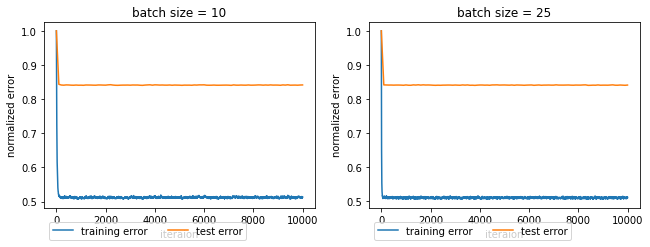

average running time = 5.388902349999995 s


In [6]:
train_iter = 10000
trial_times = 10
batch_size_list = [10, 25]
plt.figure(figsize=(3*(len(batch_size_list)+3.5),(2*len(batch_size_list)+3.5)))
total_running_time = 0
for i in range(len(batch_size_list)):
    #for 10 times
    running_time = 0
    total_training_errors = np.zeros(train_iter+1)
    total_test_errors = np.zeros(train_iter//100+1)
    
    for _ in range(trial_times):
        running_start = time.clock()
        training_errors, test_errors = SGDTrain(X_train, y_train, 0.0005, train_iter,\
                                                 NormMSELoss, batch_size=batch_size_list[i], evaluate = True, lambda_value = 0.005)
        running_time += time.clock() - running_start
        total_training_errors += training_errors
        total_test_errors += test_errors
    
    total_running_time += running_time / trial_times

    x_index1 = list(range(0,train_iter+1,1))
    x_index2 = list(range(0,train_iter+1,100))
    
    plt.subplot(2, 3,i+1)
    plt.title('batch size = ' + str(batch_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('normalized error')
    plt.plot(x_index1, total_training_errors/trial_times)
    plt.plot(x_index2, total_test_errors/trial_times)
    print("batch size: %3d; final testing error: %lf; final training error: %lf  " % (batch_size_list[i], total_test_errors[-1]/trial_times, total_training_errors[-1]/trial_times))
    plt.legend(['training error', 'test error'],\
              bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2)

plt.show()
print('average running time =', total_running_time / len(batch_size_list), 's')

Text(0.5,1,'batch size = 10')

Text(0.5,0,'iteraion')

Text(0,0.5,'normalized error')

batch size:  10; final testing error: 0.837246; final training error: 0.495314  


Text(0.5,1,'batch size = 25')

Text(0.5,0,'iteraion')

Text(0,0.5,'normalized error')

batch size:  25; final testing error: 0.837380; final training error: 0.495149  


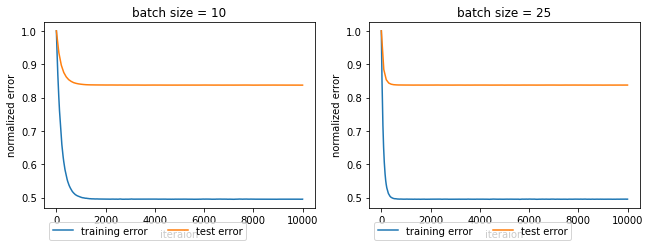

average running time = 4.3924351499999945 s


In [7]:
train_iter = 10000
trial_times = 10
batch_size_list = [10, 25]
plt.figure(figsize=(3*(len(batch_size_list)+3.5),(2*len(batch_size_list)+3.5)))
total_running_time = 0
for i in range(len(batch_size_list)):
    #for 10 times
    running_time = 0
    total_training_errors = np.zeros(train_iter+1)
    total_test_errors = np.zeros(train_iter//100+1)
    
    for _ in range(trial_times):
        running_start = time.clock()
        training_errors, test_errors = SGDTrain(X_train, y_train, 0.00005, train_iter,\
                                                 NormMSELoss, batch_size=batch_size_list[i], evaluate = True, lambda_value = 0.005)
        running_time += time.clock() - running_start
        total_training_errors += training_errors
        total_test_errors += test_errors
    
    total_running_time += running_time / trial_times

    x_index1 = list(range(0,train_iter+1,1))
    x_index2 = list(range(0,train_iter+1,100))
    
    plt.subplot(2, 3,i+1)
    plt.title('batch size = ' + str(batch_size_list[i]))
    plt.xlabel('iteraion')
    plt.ylabel('normalized error')
    plt.plot(x_index1, total_training_errors/trial_times)
    plt.plot(x_index2, total_test_errors/trial_times)
    print("batch size: %3d; final testing error: %lf; final training error: %lf  " % (batch_size_list[i], total_test_errors[-1]/trial_times, total_training_errors[-1]/trial_times))
    plt.legend(['training error', 'test error'],\
              bbox_to_anchor = (0,-0.2), loc = 3, ncol = 2)

plt.show()
print('average running time =', total_running_time / len(batch_size_list), 's')